In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
torch.manual_seed(1)

EPOCH = 10
BATCH_SIZE = 64
LR = 0.001
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
transform = transforms.ToTensor()
train_set = torchvision.datasets.MNIST(root='./mnist/', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=32)
test_set = torchvision.datasets.MNIST(root='./mnist/', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=32)

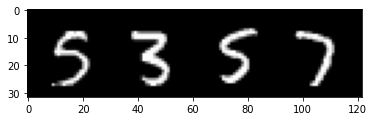

[ 5   3   5   7 ]


In [18]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
dataiter = iter(train_loader)
images, labels = dataiter.next()
images, labels = images[:4], labels[:4]
imshow(torchvision.utils.make_grid(images))
print(' '.join(str(labels.numpy())))

torch.Size([60000, 28, 28])
torch.Size([60000])


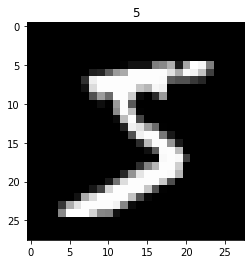

torch.Size([10000, 28, 28])
torch.Size([10000])


In [4]:
print(train_set.data.size())
print(train_set.targets.size())
plt.imshow(train_set.data[0].numpy(), cmap = 'gray')
plt.title('%d' % train_set.targets[0])
plt.show()
print(test_set.data.size())
print(test_set.targets.size())

In [5]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        self.conv1 = nn.Sequential(    # 1 * 28 * 28
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2             # 1 * (28+2+2) * (28+2+2) = 1 * 32 * 32
            ),                        # 16 * 28 * 28
            nn.ReLU(),                # 16 * 28 * 28
            nn.MaxPool2d(kernel_size=2)   # 16 * 14 * 14
        )
        self.conv2 = nn.Sequential(   # 16 * 14 * 14
            nn.Conv2d(16, 32, 5, 1, 2),  # 32 * 14 * 14
            nn.ReLU(),                # 32 * 14 * 14  
            nn.MaxPool2d(2)          # 32 * 7 * 7
        )                             
        self.fc = nn.Linear(32 * 7 * 7, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

In [6]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.conv1 = nn.Sequential(   # 1 * 28 * 28
            nn.Conv2d(1, 16, 5),      # 16 * 24 * 24
            nn.ReLU(),                # 16 * 24 * 24 
            nn.MaxPool2d(2)           # 16 * 12 * 12
        )
        self.conv2 = nn.Sequential(   # 16 * 12 * 12
            nn.Conv2d(16, 32, 5),     # 32 * 8 * 8
            nn.ReLU(),                # 32 * 8 * 8
            nn.MaxPool2d(2)           # 32 * 4 * 4
        )
        self.fc = nn.Linear(32 * 4 * 4, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

In [7]:
class Net3(nn.Module):
    def __init__(self):
        super(Net3, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(16 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [8]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.conv1 = nn.Sequential(     # 1 * 28 * 28
            nn.Conv2d(1, 6, 5, 1, 2),   # 6 * 28 * 28
            nn.ReLU(),
            nn.MaxPool2d(2)             # 6 * 14 * 14
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(6, 16, 5),        # 16 * 10 * 10
            nn.ReLU(),
            nn.MaxPool2d(2)             # 16 * 5 * 5
        )
        self.fc1 = nn.Linear(16 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [9]:
def test(net, device):
    net.to(device)
    total = 0
    correct = 0
    with torch.no_grad():
        for (inputs, labels) in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, preds = torch.max(outputs, 1)
            total += inputs.size(0)
            correct += (preds == labels).sum().item()
    print('test Accuracy: %.2f %%' % (correct * 1.0 / total * 100))
        

def train(net, device, EPOCH, LR):
    net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=LR)
    
    for epoch in range(EPOCH):
        running_loss = 0.0
        for t, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            net.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if t % 200 == 199:
                print('train_loss: %.3f' % (running_loss / 100))
                running_loss = 0.0
        test(net, device)

In [10]:
net1 = Net1()
print(net1)
train(net1, device, EPOCH, LR)

Net1(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)
train_loss: 0.988
train_loss: 0.280
train_loss: 0.206
train_loss: 0.176
test Accuracy: 98.01 %
train_loss: 0.133
train_loss: 0.115
train_loss: 0.122
train_loss: 0.103
test Accuracy: 98.47 %
train_loss: 0.087
train_loss: 0.083
train_loss: 0.087
train_loss: 0.082
test Accuracy: 98.83 %
train_loss: 0.058
train_loss: 0.071
train_loss: 0.060
train_loss: 0.071
test Accuracy: 99.07 %
train_loss: 0.049
train_loss: 0.054
train_loss: 0.061
train_loss: 0.044
test Accuracy: 98.97 %
train_loss: 0.033
train_loss: 0.047
train_loss: 0.044

In [11]:
net2 = Net2()
print(net2)
train(net2, device, EPOCH, LR)

Net2(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=512, out_features=10, bias=True)
)
train_loss: 1.227
train_loss: 0.339
train_loss: 0.246
train_loss: 0.224
test Accuracy: 97.88 %
train_loss: 0.164
train_loss: 0.142
train_loss: 0.138
train_loss: 0.123
test Accuracy: 98.53 %
train_loss: 0.107
train_loss: 0.096
train_loss: 0.100
train_loss: 0.090
test Accuracy: 98.77 %
train_loss: 0.072
train_loss: 0.086
train_loss: 0.087
train_loss: 0.085
test Accuracy: 98.52 %
train_loss: 0.069
train_loss: 0.068
train_loss: 0.063
train_loss: 0.068
test Accuracy: 98.80 %
train_loss: 0.060
train_loss: 0.058
train_loss: 0.059
train_loss: 0.050
test Accuracy:

In [12]:
net3 = Net3()
print(net3)
train(net3, device, EPOCH, LR)

Net3(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
train_loss: 1.657
train_loss: 0.459
train_loss: 0.288
train_loss: 0.260
test Accuracy: 96.95 %
train_loss: 0.201
train_loss: 0.196
train_loss: 0.177
train_loss: 0.182
test Accuracy: 97.68 %
train_loss: 0.150
train_loss: 0.140
train_loss: 0.144
train_loss: 0.128
test Accuracy: 98.32 %
train_loss: 0.116
train_loss: 0.126
train_loss: 0.118
train_loss: 0.109
test Accuracy: 98.62 %
train_loss: 0.095
train_loss: 0.107
train_loss: 0.102
train_lo

In [13]:
net4 = Net4()
print(net4)
train(net4, device, EPOCH, LR)

Net4(
  (conv1): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
train_loss: 1.404
train_loss: 0.392
train_loss: 0.321
train_loss: 0.267
test Accuracy: 97.16 %
train_loss: 0.190
train_loss: 0.195
train_loss: 0.162
train_loss: 0.145
test Accuracy: 98.30 %
train_loss: 0.141
train_loss: 0.125
train_loss: 0.117
train_loss: 0.127
test Accuracy: 98.40 %
train_loss: 0.100
train_loss: 0.106
train_loss: 0.092
train_loss: 0.104
test Accuracy: 98.74 %
train_loss: 0.093
train_loss: 0.078
train_loss

Epoch:  0 | train loss: 2.3042 | test accuracy: 0.11


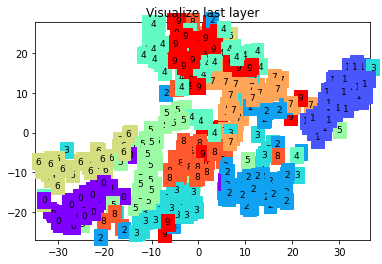

Epoch:  0 | train loss: 0.3200 | test accuracy: 0.89


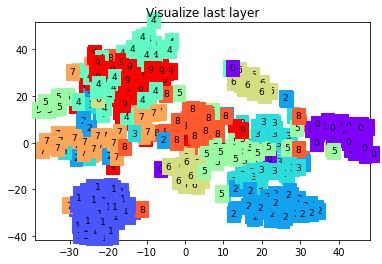

Epoch:  0 | train loss: 0.1990 | test accuracy: 0.93


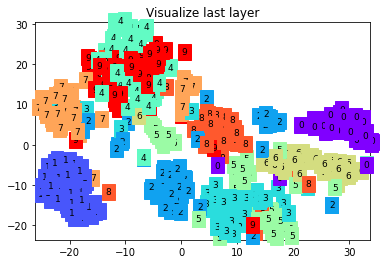

Epoch:  0 | train loss: 0.0915 | test accuracy: 0.95


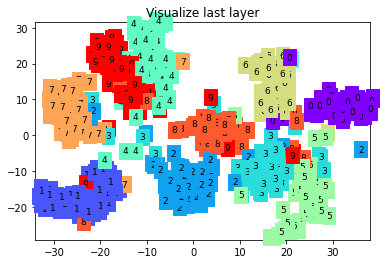

Epoch:  0 | train loss: 0.0858 | test accuracy: 0.96


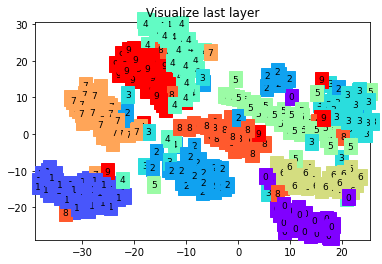

Epoch:  0 | train loss: 0.0761 | test accuracy: 0.96


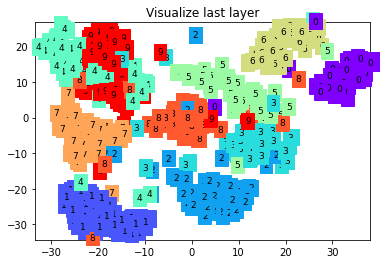

Epoch:  0 | train loss: 0.1630 | test accuracy: 0.97


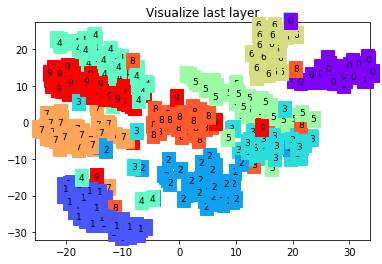

Epoch:  0 | train loss: 0.0348 | test accuracy: 0.97


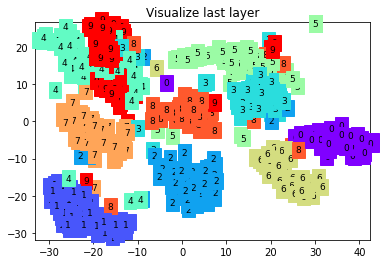

Epoch:  0 | train loss: 0.0150 | test accuracy: 0.98


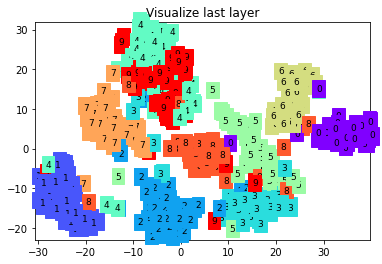

Epoch:  0 | train loss: 0.0393 | test accuracy: 0.98


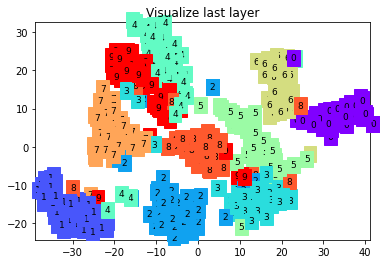

Epoch:  1 | train loss: 0.1556 | test accuracy: 0.97


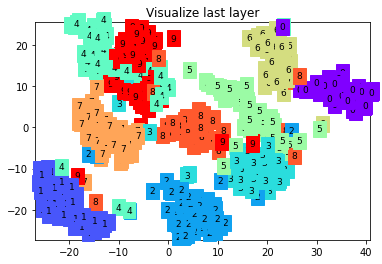

Epoch:  1 | train loss: 0.0871 | test accuracy: 0.98


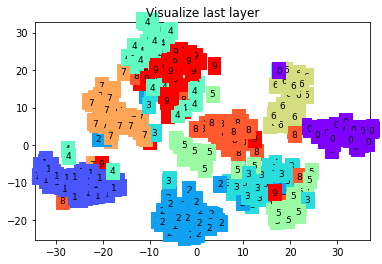

Epoch:  1 | train loss: 0.0906 | test accuracy: 0.98


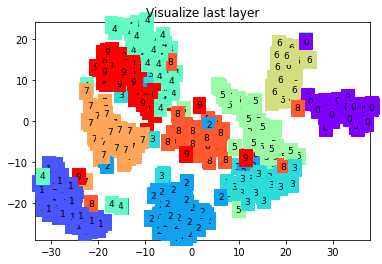

Epoch:  1 | train loss: 0.1386 | test accuracy: 0.98


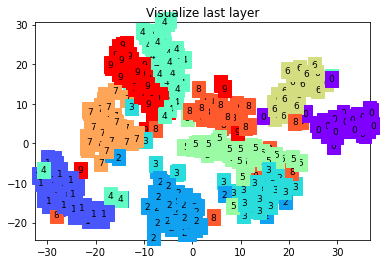

Epoch:  1 | train loss: 0.0511 | test accuracy: 0.98


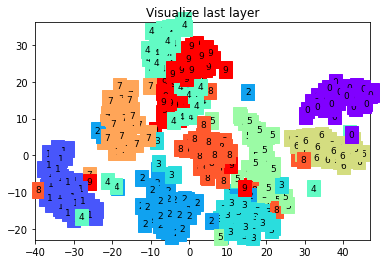

Epoch:  1 | train loss: 0.0386 | test accuracy: 0.98


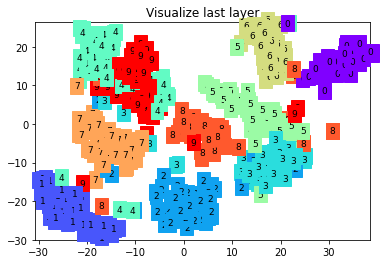

Epoch:  1 | train loss: 0.0413 | test accuracy: 0.98


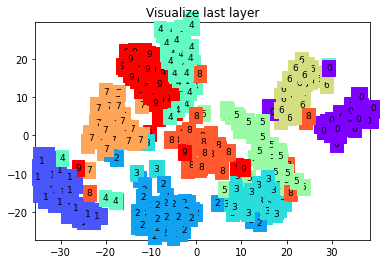

Epoch:  1 | train loss: 0.0578 | test accuracy: 0.98


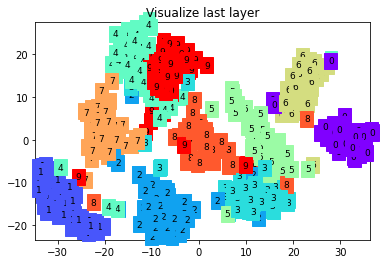

Epoch:  1 | train loss: 0.0037 | test accuracy: 0.98


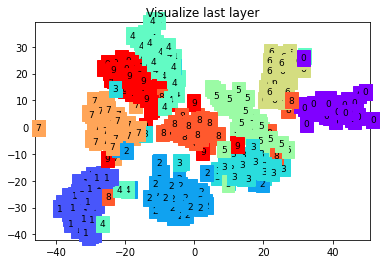

Epoch:  1 | train loss: 0.0665 | test accuracy: 0.98


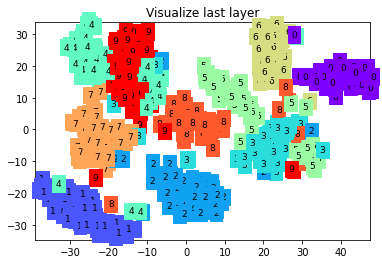

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 28, 28)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=5,              # filter size
                stride=1,                   # filter movement/step
                padding=2,                  # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(kernel_size=2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),     # output shape (32, 14, 14)
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)           # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output, x    # return x for visualization

# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
try: from sklearn.manifold import TSNE; HAS_SK = True
except: HAS_SK = False; print('Please install sklearn for layer visualization')
def plot_with_labels(lowDWeights, labels):
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer'); plt.show(); plt.pause(0.01)

plt.ion()
test_x = torch.unsqueeze(test_set.data, dim=1).type(torch.FloatTensor)[:2000]/255.   # shape from (2000, 28, 28) to (2000, 1, 28, 28), value in range(0,1)
test_y = test_set.targets[:2000]
test_x = test_x.to(device)
test_y = test_y.to(device)

# training and testing
net = CNN()
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=LR)

for epoch in range(2):
    for t, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        net.zero_grad()
        outputs, _ = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if t % 100 == 0:
            test_output, last_layer = net(test_x)
            last_layer = last_layer.cpu()
            pred_y = torch.max(test_output, 1)[1].data
            accuracy = (pred_y == test_y).sum().item() / float(test_y.size(0))
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item(), '| test accuracy: %.2f' % accuracy)
            if HAS_SK:
                # Visualization of trained flatten layer (T-SNE)
                tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
                plot_only = 500
                low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
                labels = test_y.cpu().numpy()[:plot_only]
                plot_with_labels(low_dim_embs, labels)
plt.ioff()


In [15]:
test_output, _ = net(test_x[:10])
pred_y = torch.max(test_output.cpu(), 1)[1].data.numpy().squeeze()
print(pred_y, 'prediction number')
print(test_y.cpu()[:10].numpy(), 'real number')

[7 2 1 0 4 1 4 9 5 9] prediction number
[7 2 1 0 4 1 4 9 5 9] real number
